# Back Propagation

## Imports

In [1]:
import math
import random

import numpy as np
import pandas as pd

from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.models import ColumnDataSource

## Problem 1

<img src="img/img1.png" />

### Point A)

This NN is simple and can be translated into a function.
$$ \text{Output} = \varphi (\varphi(x_1 \times w_{11} + x_2 \times w_{12} + b_1) \times w_{23} + x_1 \times w_{21} + x_2 \times w_{22} + b_2) $$  
Where the step function is defined below.

In [2]:
## Defining the step function
def step_func(x):
    if x <= 0:
        return 0
    elif x > 0:
        return 1

In [3]:
## Create the network
def network(x1, x2):
    w11 = 1.0
    w12 = 1.0
    w21 = 1.0
    w22 = 1.0
    w23 = -2.0
    b1 = -1.5
    b2 = -0.5
    
    return step_func(step_func(x1 * w11 + x2 * w12 + b1)*w23 + x1 * w21 + x2 * w22 + b2)

In [4]:
## Create x and y points
def create_0_1_plane(granularity = 80, MIN = 0, MAX = 1, network = network):
    points = []
    for i in np.linspace(MIN, MAX, granularity):
        for j in np.linspace(MIN, MAX, granularity):
            points.append([i, j])
            
    x = list(zip(*points))[0]
    y = list(zip(*points))[1]
    network_results = [network(*point) for point in points]
    return x, y, network_results
            
x, y, network_results = create_0_1_plane()   

Visually, we can see the decision boundary 

In [5]:
def plot_nn_1(x, y, network_results):
    output_notebook()

    color_palette = ['#FF0000', '#00FFFF']
    mapper = linear_cmap(field_name='network_results', palette=color_palette ,low=min(network_results) ,high=max(network_results))
    source = ColumnDataSource(dict(x=x,y=y, network_results=network_results))

    p = figure(width=400, height=400)

    # add a circle renderer with a size, color, and alpha
    p.dot(x='x', y='y', size=20, color=mapper, alpha=0.5, source = source)

    # show the results
    show(p)
    
plot_nn_1(x, y, network_results)

Loading BokehJS ...

Plot 1: The points in red are equal to 0. The points in blue are equal to 1. The boundary lines will be $y = -x + 0.5$ and $y = -x + 1.5$

### Point B)

By using the plot in *point A*, the truth table will be:

| X | Y | Signal |
|-------|-------|--------|
| 0     | 0     | 0      |
| 0     | 1     | 1      |
| 1     | 0     | 1      |
| 1     | 1     | 0      |

### Point C)

Assume a learning rate of $\eta = 0.01$

As for the weight correction, it has the following formulation:

![img10](img/img10.png)

Where $\eta$ is the learning rate.

More generally,   
![img3](img/img3.png)

Where

![img11](img/img11.png)

and  
![img12](img/img12.png)


And finally

![img13](img/img13.png)

Let us apply the generalized delta rule ($\alpha = 0$), which  has, with momentum ($\alpha$) equal to 0.

Decyphering the partial derivatives

![img2](img/img2.png)

Derived from these:   
![img4](img/img4.png)

**It helps me to translate these into words, so my understanding is that,**

-----
![img5](img/img5.png)   
This means the derivative of the Error energy by the error is the error itself   

-----
![img6](img/img6.png)  
These terms mean that the derivative of the error by the real output equal $-1$   

-----
![img7](img/img7.png)   
That the derivative of the real output by the local input weights (induced local field) is going to result in the derivative of the activation func. in function to the local field.  

-----
![img8](img/img8.png)  
And that the derivative of the local field by the local weights equals the real output of the previous neuron.

-----

The final definition is that of error.   
![img9](img/img9.png)  

Which translates to the difference between the desired output and the real output.

Going back to the exercise at hands.

**Using the step function, the point $(2,2)$ helds the result 1. Lets look at the result it helds using the sigmoid function.**

In [6]:
learning_rate = 0.01

In [7]:
network(2, 2) # NN using the step function

1

In [8]:
# Define sigmoid (https://www.delftstack.com/pt/howto/python/sigmoid-function-python/)
def sigmoid(x, a = 1):
    if x >= 0:
        z = math.exp(a*(-x))
        sig = 1 / (1 + z)
        return sig
    else:
        z = math.exp(a*(-x))
        sig = z / (1 + z)
        return sig

def deriv_sigmoid(x, a = 1):
    return a*x*(1-x)

In [9]:
# Simple translation from math to code of backprop
def backprop(e, localf, prev_output):
    return round(-e*deriv_sigmoid(localf)*prev_output,5)

In [10]:
## Create the network
def network_sigmoid(x1, x2, outputs = False):
    w11 = 1.0
    w12 = 1.0
    w21 = 1.0
    w22 = 1.0
    w23 = -2.0
    b1 = -1.5
    b2 = -0.5
    
    if outputs:
        print(f'Hidden Layer neuron (1) output: {round(sigmoid(x1 * w11 + x2 * w12 + b1),5)}')
        print(f'OUTPUT AKA Hidden Layer neuron (2) output: {round(sigmoid(sigmoid(x1 * w11 + x2 * w12 + b1)*w23 + x1 * w21 + x2 * w22 + b2),5)}')
    else:
        return round(sigmoid(sigmoid(x1 * w11 + x2 * w12 + b1)*w23 + x1 * w21 + x2 * w22 + b2),5)

The output of the network will be:

In [11]:
network_sigmoid(2,2)

0.83912

The error will be

In [12]:
e_1 = 1 - network_sigmoid(2,2)
e_1

0.16088000000000002

Let us update the weight $w_{21}$, which recieved the previous neuron output equal to $2$ (feature $x_1$)

In [13]:
# The current weight
w21 = 1.0
#Backprop
bp_w21 = backprop(e_1, network_sigmoid(2,2), 2)
# Update
w_21 = w21 + learning_rate*bp_w21

w_21

0.9995656

Following the update the weight $w_{22}$, which recieved the previous neuron output equal to $2$ (feature $x_2$)

In [14]:
# The current weight
w22 = 1.0
#Backprop
bp_w22 = backprop(e_1, network_sigmoid(2,2), 2)
# Update
w_22 = w22 + learning_rate*bp_w22

w_22

0.9995656

It gets tricky now, $w_23$ recieved as input, the output of neuron (1). I added in the function the possibity to output these results, but it's usually in the memory if the network.  
The hidden layer output will be $0.92414$

In [15]:
network_sigmoid(2,2, True)

Hidden Layer neuron (1) output: 0.92414
OUTPUT AKA Hidden Layer neuron (2) output: 0.83912


So the output of the previous neuron is going to be $0.92414$

In [16]:
# The current weight
w23 = 1.0
#Backprop
bp_w23 = backprop(e_1, network_sigmoid(2,2), 0.92414)
# Update
w_23 = w23 + learning_rate*bp_w23

w_23

0.9997993

And finally, for this layer, the bias $b_2$, which has te output of $1$

In [17]:
# The current weight
w_b2 = -0.5
#Backprop
bp_b2 = backprop(e_1, network_sigmoid(2,2), 1)
# Update
w_b2 = w_b2 + learning_rate*bp_b2

w_b2

-0.5002172

Now, the error that was passed to neuron (1), which is a bit more complex.

So, we know the weight $w_{23}$ is equal to $-2$

In this equation:

![img13](img/img13.png)

We only have one sum, which is that of neuron (2), with weight $-2$. Now looking at the $\delta_k$

![img12](img/img12.png)

The error component is part of the previous step (?) error, which in this case is stored in `e_1` variable.  
The derivative of the local field is `network_sigmoid(2,2)` again.

In [18]:
def delta_bprop_sum(l_error, l_activ, l_weight):
    # Assumes all lists are the same size
    sum_component = 0
    for e, i in enumerate(l_error):
        sum_component += l_error[e] * deriv_sigmoid(l_activ[e]) * l_weight[e]
    return round(sum_component,5)

Now we just multiply this result by the sigmoid derivative of the output in this neuron, which is $0.92414$

In [19]:
delta_1 = round(deriv_sigmoid(0.92414) * delta_bprop_sum([e_1], [network_sigmoid(2,2)], [-2]),5)

delta_1

-0.00305

And now, update the weights $w_{11}$, $w_{12}$ and $b_1$

In [20]:
w_11 = 1
w_12 = 1
w_b1 = -1.5

bp_w11 = learning_rate*delta_1*2 # 2 is the first term of the input (2,2)
bp_w12 = learning_rate*delta_1*2 
bp_b1 = learning_rate*delta_1*1

w11 = w_11 + bp_w11
w12 = w_12 + bp_w12
w_b1 = w_b1 + bp_b1

print(f'Weight 11: {w11}')
print(f'Weight 12: {w12}')
print(f'Weight b1: {w_b1}')

Weight 11: 0.999939
Weight 12: 0.999939
Weight b1: -1.5000305


In [21]:
# Track of weights:

w_11 = 0.999939
w_12 = 0.999939
w_b1 = -1.5000305
w_21 = 0.9995656
w_22 = 0.9995656
w_23 = 0.9997993
w_b2 = -0.5002172

Let us look at the result of this update with the step function.

In [22]:
## Create the network
def network_updated(x1, x2):
    w11 = 0.999939
    w12 = 0.999939
    w21 = 0.9995656
    w22 = 0.9995656
    w23 = 0.9997993
    b1 = -1.5000305
    b2 = -0.5002172
    
    return step_func(step_func(x1 * w11 + x2 * w12 + b1)*w23 + x1 * w21 + x2 * w22 + b2)

x, y, network_results = create_0_1_plane(network = network_updated)   
plot_nn_1(x, y, network_results)

Loading BokehJS ...

## Problem 2

![img14](img/img14.png)

The first step should be to create the data points.

The XOR table is the following:

| X | Y | Signal |
|-------|-------|--------|
| 0     | 0     | 0      |
| 0     | 1     | 1      |
| 1     | 0     | 1      |
| 1     | 1     | 0      |

### Point A)

In [23]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
random.seed(1337)

def p2_create_points(size = 10000):
    input_l = list()
    output_l = list()
    for i in range(size):
        a = random.randint(0,1)
        b = random.randint(0,1)
        input_l.append([a,b])
        output_l.append(a^b)
    return input_l, output_l

X, y = p2_create_points()
df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(X, y, train_size=0.9)

The next step should be to implement the *NN* with a library. I will use Tensorflow in this case.

In [24]:
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop

def get_model(activation_function = 'sigmoid', optimizer_momentum = 0):
    input_tensor = Input((2,), name = 'input_layer')
    hidden_1 = Dense(1, activation = activation_function, name = 'dense_layer_1')(input_tensor)
    hidden_2 = Dense(1, activation = activation_function, name = 'dense_layer_2')(input_tensor)
    concat_layer = Concatenate(name = 'concat_layer')([hidden_1, hidden_2])
    output_tensor = Dense(1, activation = activation_function, name = 'output_layer')(concat_layer)
    
    
    model = Model(input_tensor, output_tensor)
    
    opt = RMSprop(momentum = optimizer_momentum)
    model.compile(optimizer = opt,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    return model

2022-03-01 23:39:34.012466: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


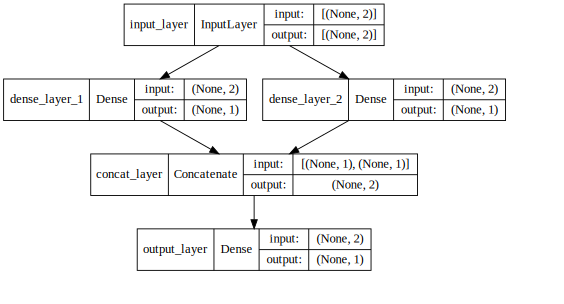

In [27]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(get_model(), show_shapes=True, dpi=65).create(prog='dot', format='svg'))

Let us first look at the network loss with and without momentum. fixing the activation function on the logistic.

In [28]:
momentum_results = {}
momentums = [0,0.01,0.1,0.2,1]

for mom in momentums:
  # Get a new model with the current activation
  model = get_model(optimizer_momentum = mom)
  # Fit the model and store the history results
  h_callback = model.fit(df_train_X, df_train_y, validation_data = (df_test_X, df_test_y), epochs = 20, verbose = 0)
  momentum_results[mom] = h_callback

<AxesSubplot:>

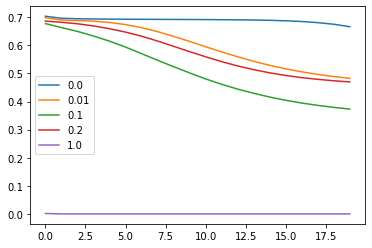

In [29]:
val_loss_momentum = {k:v.history['val_loss'] for k, v in momentum_results.items()}

val_loss_mom_curves = pd.DataFrame(val_loss_momentum)
val_loss_mom_curves.plot()

With the exception of the momentum $= 1$, whose loss stays around the same for each epoch, the other momentums have a tendency to decrease, with $0.1$ having a better result from this small experiment. 

Let us fix the momentum to $0.1$ in the experiment with different activation functions.

In [30]:
actiavation_results = {}
activations = ['relu','tanh', 'sigmoid']

for activ in activations:
  # Get a new model with the current activation
  model = get_model(activation_function = activ, optimizer_momentum = 0.1)
  # Fit the model and store the history results
  h_callback = model.fit(df_train_X, df_train_y, validation_data = (df_test_X, df_test_y), epochs = 20, verbose = 0)
  actiavation_results[activ] = h_callback

<AxesSubplot:>

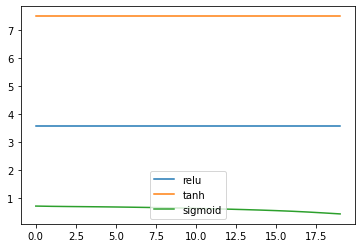

In [31]:
val_loss_activation = {k:v.history['val_loss'] for k, v in actiavation_results.items()}

val_loss_activation_curves = pd.DataFrame(val_loss_activation)
val_loss_activation_curves.plot()

The logistic activation function his a clear winner when it comes to reducing the loss each epoch. Maybe because the momentum was fixed and this specific value helps the sigmoid?  
Let us look at the mix of both activation and momentum.

In [32]:
mix_results = {}
activations = ['relu','tanh', 'sigmoid']
momentums = [0,0.01,0.1,0.2,1]

for activ in activations:
    for mom in momentums:
      # Get a new model with the current activation
      model = get_model(activation_function = activ, optimizer_momentum = mom)
      # Fit the model and store the history results
      h_callback = model.fit(df_train_X, df_train_y, validation_data = (df_test_X, df_test_y), epochs = 20, verbose = 0)
      mix_results[f'{activ}_{mom}'] = h_callback

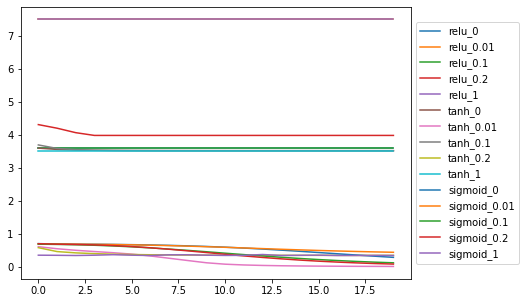

In [33]:
val_loss_mix = {k:v.history['val_loss'] for k, v in mix_results.items()}

val_loss_mix_curves = pd.DataFrame(val_loss_mix)
ax = val_loss_mix_curves.plot(figsize=(7,5))
ax.legend(loc='center left',  bbox_to_anchor=(1.0, 0.5))

Let us introduce a limit on y axis.

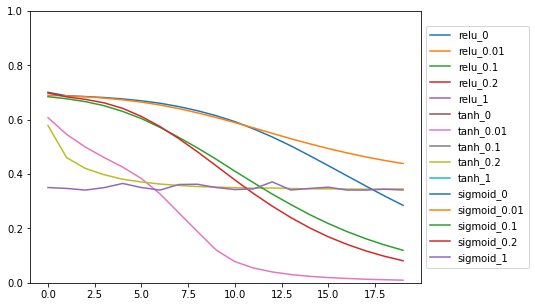

In [34]:
ax = val_loss_mix_curves.plot(ylim=(0,1),figsize=(7,5))
ax.legend(loc='center left',  bbox_to_anchor=(1.0, 0.5))

The loss being high with some activations was due to the momentum parameter chosen, as it can be seen for example *tanh* activation with $0.01$ momentum. 

### Point B


In [43]:
def model_2(activation_function = 'sigmoid', optimizer_momentum = 0):
    
    inputs = Input((2,))
    hidden_1 = Dense(1, activation=activation_function, input_shape=(2,))(inputs)
    concat_layer = Concatenate(axis=-1)([inputs, hidden_1])
    output = Dense(1, activation=activation_function)(concat_layer)
    
    p1_model = Model(inputs=inputs, outputs=output)
    
    opt = RMSprop(momentum = optimizer_momentum)
    p1_model.compile(optimizer = opt,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    
    return p1_model

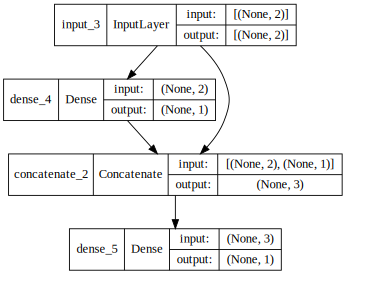

In [44]:
SVG(model_to_dot(model_2(), show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [48]:
mix_results = {}
activations = ['relu','tanh', 'sigmoid']
momentums = [0,0.01,0.1]

model_name = 'problem2'
for activ in activations:
    for mom in momentums:
      # Get a new model with the current activation
      model = get_model(activation_function = activ, optimizer_momentum = mom)
      # Fit the model and store the history results
      h_callback = model.fit(df_train_X, df_train_y, validation_data = (df_test_X, df_test_y), epochs = 20, verbose = 0)
      mix_results[f'{model_name}_{activ}_{mom}'] = h_callback
    
model_name = 'problem1'
for activ in activations:
    for mom in momentums:
      # Get a new model with the current activation
      model = model_2(activation_function = activ, optimizer_momentum = mom)
      # Fit the model and store the history results
      h_callback = model.fit(df_train_X, df_train_y, validation_data = (df_test_X, df_test_y), epochs = 20, verbose = 0)
      mix_results[f'{model_name}_{activ}_{mom}'] = h_callback

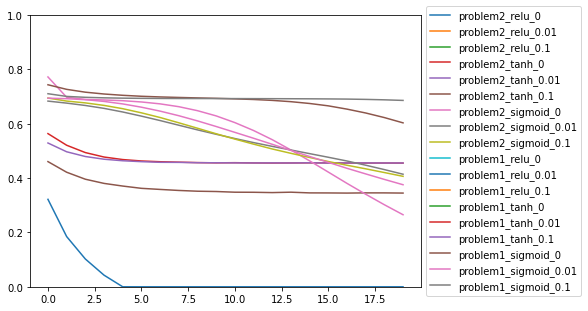

In [49]:
val_loss_mix = {k:v.history['val_loss'] for k, v in mix_results.items()}

val_loss_mix_curves = pd.DataFrame(val_loss_mix)
ax = val_loss_mix_curves.plot(ylim=(0,1), figsize=(7,5))
ax.legend(loc='center left',  bbox_to_anchor=(1.0, 0.5))